In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from scipy.stats import mode

from Kmeans import Kmeans
from AutoEncoder import Autoencoder
from Evaluation_metrics import EvaluationMetrics
from manualPCA import ManualPCA
from GMM import GaussianMixtureModel, StandardScaler  # Assuming StandardScaler is in GMM.py as shown in Exp 2

np.random.seed(42)

# Load Dataset
df = load_breast_cancer(as_frame=True).frame

# Encode labels: M=1, B=0
y = (df["target"] == 1).astype(int).values
X_raw = df.drop(columns=["target"]).values

# Standardization 
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0) + 1e-8
X = (X_raw - X_mean) / X_std

print(f"Data Loaded & Standardized. Shape: {X.shape}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data Loaded & Standardized. Shape: (569, 30)


## Experiment 1 (Kmeans on original data)

Running Exp 1 Analysis for k=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...
k=1: Iner=17070 | Sil=0.000 | DB=0.000 | ARI=0.000
k=2: Iner=11596 | Sil=0.345 | DB=1.309 | ARI=0.677
k=3: Iner=10063 | Sil=0.314 | DB=1.530 | ARI=0.513
k=4: Iner=9260 | Sil=0.284 | DB=1.487 | ARI=0.554
k=5: Iner=8893 | Sil=0.201 | DB=1.529 | ARI=0.483
k=6: Iner=8128 | Sil=0.149 | DB=1.712 | ARI=0.277
k=7: Iner=7808 | Sil=0.152 | DB=1.572 | ARI=0.268
k=8: Iner=7209 | Sil=0.144 | DB=1.621 | ARI=0.223
k=9: Iner=6831 | Sil=0.142 | DB=1.523 | ARI=0.228
k=10: Iner=6671 | Sil=0.138 | DB=1.545 | ARI=0.198


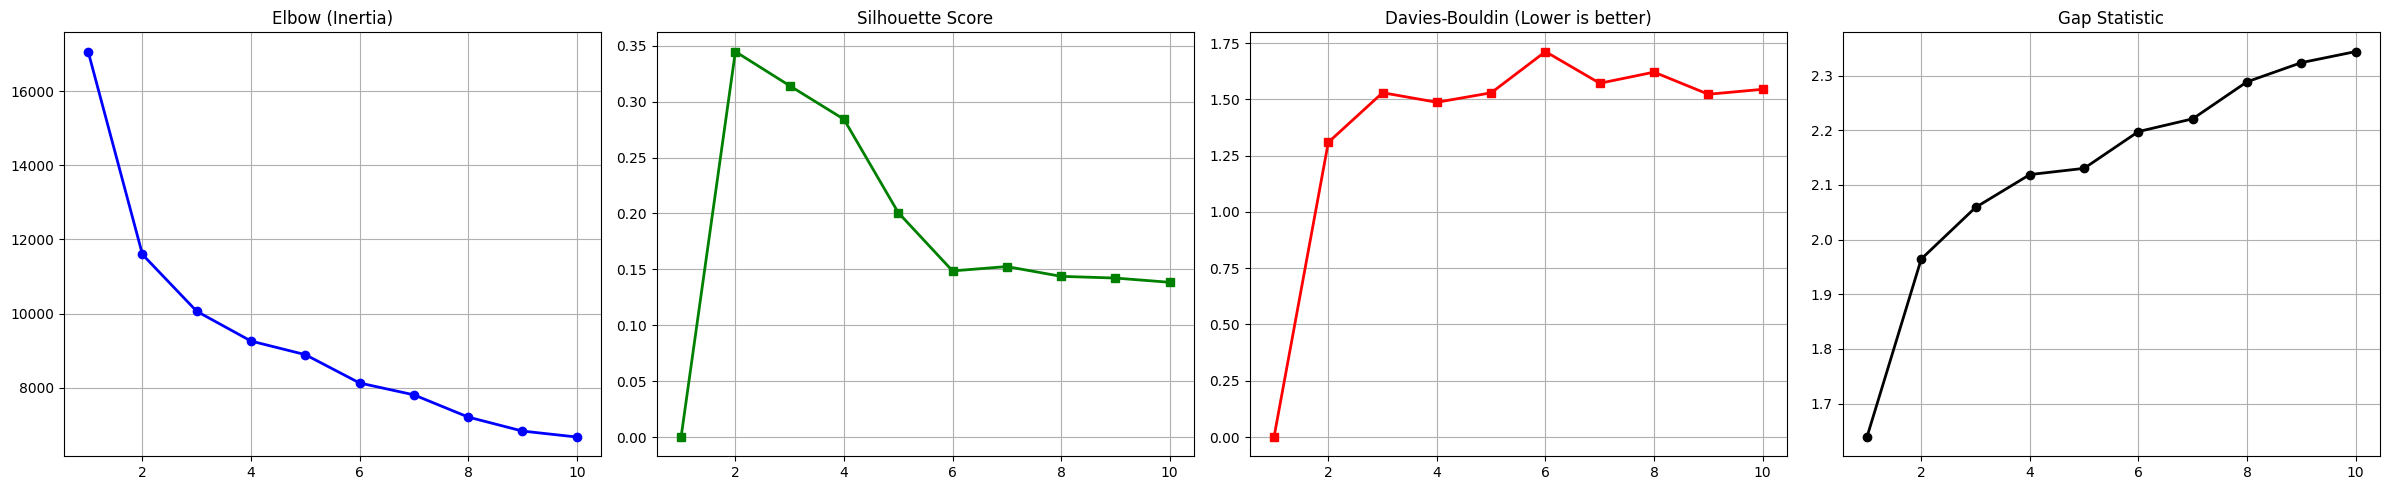


Comparing initialization methods for k=2...

Method          | Avg Iterations  | Avg Time (ms)  
kpp             | 7.70            | 14.00          
random          | 7.50            | 5.13           


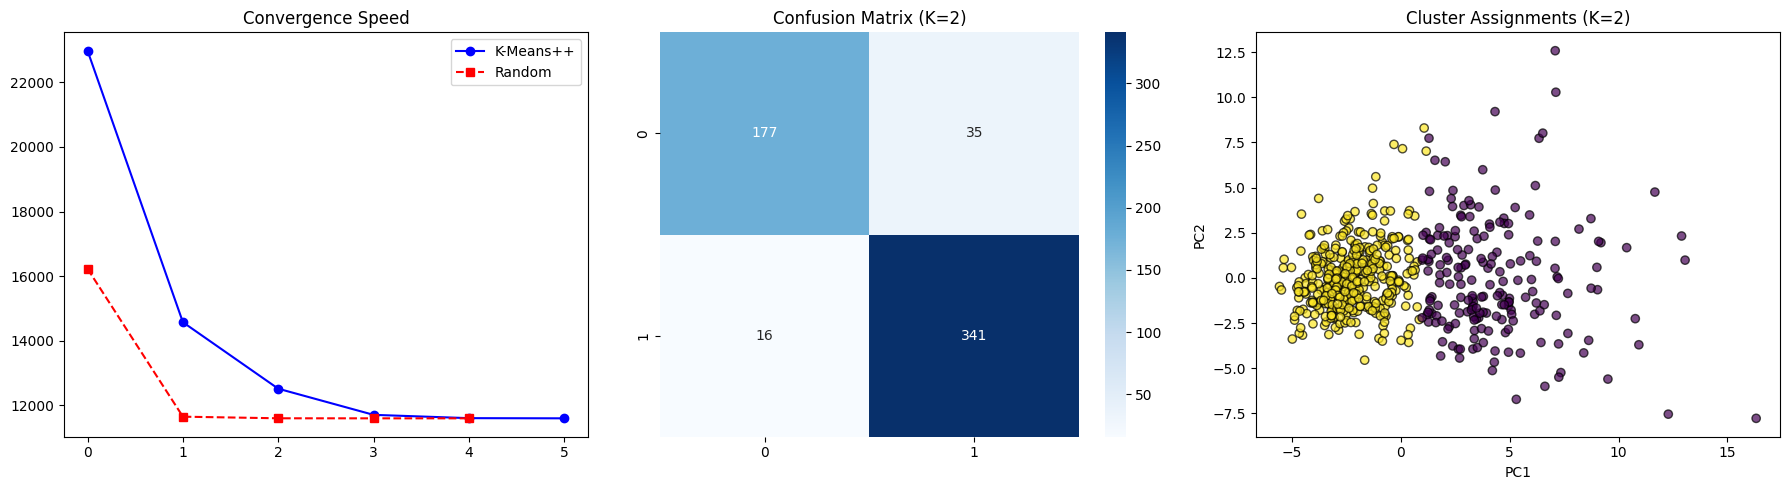

In [10]:


if 'GLOBAL_RESULTS' not in locals(): GLOBAL_RESULTS = []
if 'PAIRED_DATA' not in locals(): PAIRED_DATA = {
    'KMeans': [], 'GMM': [], 'PCA-KM': [], 
    'PCA-GMM': [], 'AE-KM': [], 'AE-GMM': []
}

def map_labels(y_true, y_pred):
    labels = np.unique(y_pred)
    new_pred = np.zeros_like(y_pred)
    for l in labels:
        mask = (y_pred == l)
        if np.sum(mask) > 0:
            sub_y = y_true[mask]
            if len(sub_y) > 0:
                m = mode(sub_y, keepdims=True)[0][0]
                new_pred[mask] = m
    return new_pred

# --- EXPERIMENT 1: K-MEANS ---
k_range = range(1, 11)
n_refs = 5

# Metrics Storage
inertias = []
sil_scores = []
gap_values = []
dbi_scores = []
chi_scores = []

best_k = 3 
best_ari = -1
best_record = {}

print(f"Running Exp 1 Analysis for k={list(k_range)}...")

for k in k_range:
    # 1. Train
    t0 = time.time()
    model = Kmeans(k=k, init="kpp", max_iter=300) 
    model.fit(X)
    t_elapsed = time.time() - t0
    
    labels = model.predict(X)
    inertia = model.inertia_history[-1]
    inertias.append(inertia)
    
    # 2. Internal Metrics
    if k > 1:
        sil = EvaluationMetrics.silhouette_score(X, labels)
        db = EvaluationMetrics.davies_bouldin(X, labels)
        ch = EvaluationMetrics.calinski_harabasz(X, labels)
    else:
        sil, db, ch = 0, 0, 0
        
    sil_scores.append(sil)
    dbi_scores.append(db)
    chi_scores.append(ch)
    
    # 3. Gap Statistic
    ref_log_inertias = []
    for _ in range(n_refs):
        X_ref = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), X.shape)
        ref_model = Kmeans(k=k, init="kpp", max_iter=100)
        ref_model.fit(X_ref)
        ref_log_inertias.append(np.log(ref_model.inertia_history[-1] + 1e-10))
    gap = np.mean(ref_log_inertias) - np.log(inertia + 1e-10)
    gap_values.append(gap)
    
    # 4. External Metrics (For Global Reporting)
    ari = EvaluationMetrics.adjusted_rand_index(y, labels)
    nmi = EvaluationMetrics.normalized_mutual_info(y, labels)
    pur = EvaluationMetrics.purity(y, labels)
    
    print(f"k={k}: Iner={inertia:.0f} | Sil={sil:.3f} | DB={db:.3f} | ARI={ari:.3f}")

    # Store Best Result for Global Table (Preferably based on ARI or Silhouette)
    if ari > best_ari:
        best_ari = ari
        best_record = {
            'Method': 'KMeans',
            'ARI': ari, 'NMI': nmi, 'Purity': pur,
            'Silhouette': sil, 'DBI': db, 'CH': ch, 'WCSS': inertia,
            'Time (s)': t_elapsed
        }

# Append to Global Results
GLOBAL_RESULTS = [res for res in GLOBAL_RESULTS if res['Method'] != 'KMeans'] # Clean old runs
GLOBAL_RESULTS.append(best_record)

# --- Plots ---
fig, ax = plt.subplots(1, 4, figsize=(24, 5))

ax[0].plot(k_range, inertias, 'bo-', linewidth=2)
ax[0].set_title('Elbow (Inertia)')
ax[0].grid(True)

ax[1].plot(k_range, sil_scores, 'gs-', linewidth=2)
ax[1].set_title('Silhouette Score')
ax[1].grid(True)

ax[2].plot(k_range, dbi_scores, 'rs-', linewidth=2)
ax[2].set_title('Davies-Bouldin (Lower is better)')
ax[2].grid(True)

ax[3].plot(k_range, gap_values, 'ko-', linewidth=2)
ax[3].set_title('Gap Statistic')
ax[3].grid(True)
plt.tight_layout(); plt.show()

# --- Part 2: Comparison & Statistical Data Collection ---
k_stat = 2 
n_trials = 10
results = {'kpp': {'iters': [], 'times': [], 'inertias': []}, 'random': {'iters': [], 'times': [], 'inertias': []}}
PAIRED_DATA['KMeans'] = [] # Reset for fresh run

print(f"\nComparing initialization methods for k={k_stat}...")

for init_method in ['kpp', 'random']:
    for _ in range(n_trials):
        model = Kmeans(k=k_stat, init=init_method, max_iter=500, tol=1e-4)
        start_time = time.time()
        model.fit(X)
        results[init_method]['iters'].append(model.n_iter_)
        results[init_method]['times'].append(time.time() - start_time)
        results[init_method]['inertias'].append(model.inertia_history[-1])
        
        # Collect ARI for Paired T-Test (Only for KPP usually)
        if init_method == 'kpp':
            l_stat = model.predict(X)
            PAIRED_DATA['KMeans'].append(EvaluationMetrics.adjusted_rand_index(y, l_stat))

# Comparison Table
print(f"\n{'Method':<15} | {'Avg Iterations':<15} | {'Avg Time (ms)':<15}")
for method in ['kpp', 'random']:
    avg_iter = np.mean(results[method]['iters'])
    avg_time = np.mean(results[method]['times']) * 1000
    print(f"{method:<15} | {avg_iter:<15.2f} | {avg_time:<15.2f}")

# --- Visuals: Best Model ---
# 1. Convergence
pca = ManualPCA(n_components=2)
X_pca_2d = pca.fit_transform(X)
model_kpp = Kmeans(k=k_stat, init='kpp', max_iter=300); model_kpp.fit(X)
y_pred_kpp = model_kpp.predict(X)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(model_kpp.inertia_history, 'b-o', label='K-Means++')
model_rnd = Kmeans(k=k_stat, init='random', max_iter=300); model_rnd.fit(X)
axes[0].plot(model_rnd.inertia_history, 'r--s', label='Random')
axes[0].set_title('Convergence Speed')
axes[0].legend()

# 2. Confusion Matrix (Mapped)
y_mapped = map_labels(y, y_pred_kpp)
sns.heatmap(confusion_matrix(y, y_mapped), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'Confusion Matrix (K={k_stat})')

# 3. 2D Cluster Projection
axes[2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_pred_kpp, cmap='viridis', edgecolor='k', alpha=0.7)
axes[2].set_title(f'Cluster Assignments (K={k_stat})')
axes[2].set_xlabel('PC1'); axes[2].set_ylabel('PC2')

plt.tight_layout(); plt.show()

## Experiment 2 (GMM on Original Data)

Running Exp 2: GMM Analysis...

Top configurations by BIC:
 K Covariance_Type      BIC      AIC   ARI
 2            full 16194.22 11889.43 0.792
 6            tied 16439.91 13616.39 0.589
 7            tied 16469.35 13511.17 0.523
 4            tied 16883.68 14329.47 0.667
 5            tied 16975.29 14286.43 0.629


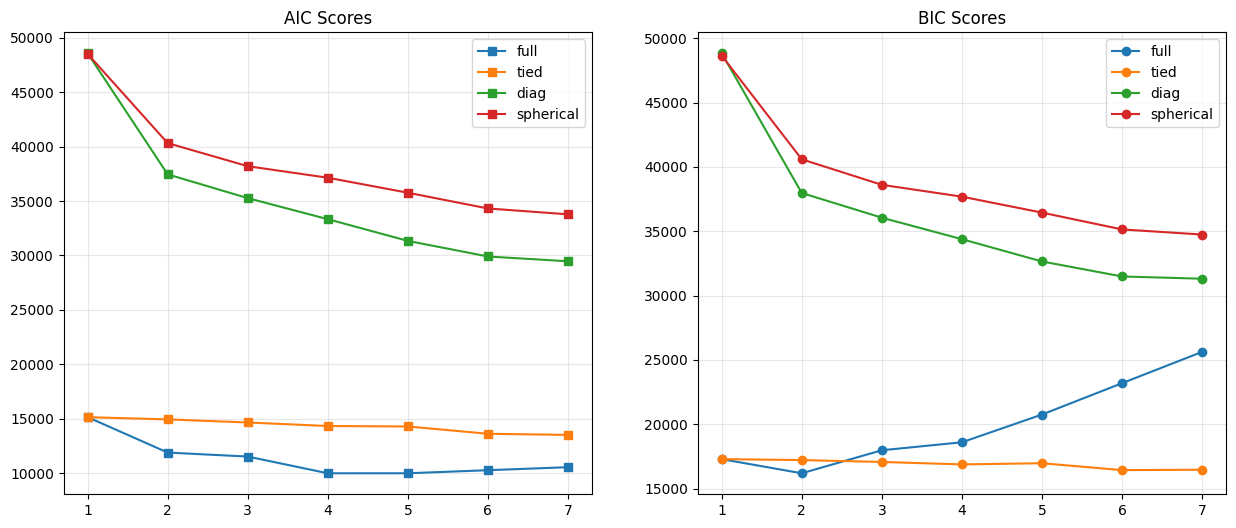

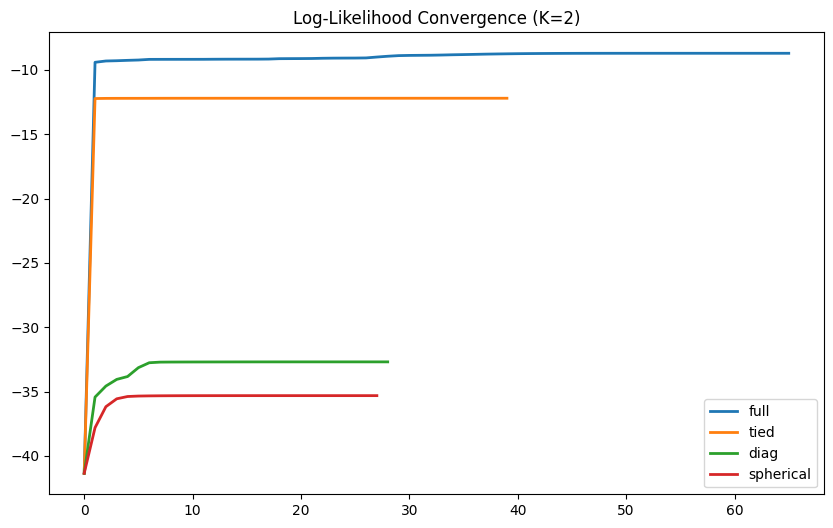

In [ ]:

if 'GLOBAL_RESULTS' not in locals(): GLOBAL_RESULTS = []
if 'PAIRED_DATA' not in locals(): PAIRED_DATA = {
    'KMeans': [], 'GMM': [], 'PCA-KM': [], 'PCA-GMM': [], 'AE-KM': [], 'AE-GMM': []
}

# --- EXPERIMENT 2 ---
ks = range(1, 8)
cov_types = ['full', 'tied', 'diag', 'spherical']
results = []
convergence_log = []

best_gmm_ari = -1
best_gmm_config = None
best_gmm_record = {}

print("Running Exp 2: GMM Analysis...")

for t in cov_types:
    for k in ks:
        try:
            t0 = time.time()
            model = GaussianMixtureModel(n_components=k, covariance_type=t, random_state=42).fit(X)
            t_elapsed = time.time() - t0
            
            probs, _ = model._e_step(X)
            labels = np.argmax(probs, axis=1)

            bic = model.bic(X)
            aic = model.aic(X)
            
            if k > 1:
                sil = EvaluationMetrics.silhouette_score(X, labels)
                db = EvaluationMetrics.davies_bouldin(X, labels)
            else:
                sil, db = 0, 0
                
            ari = EvaluationMetrics.adjusted_rand_index(y, labels)
            nmi = EvaluationMetrics.normalized_mutual_info(y, labels)
            pur = EvaluationMetrics.purity(y, labels)

            results.append({
                'K': k, 'Covariance_Type': t, 
                'BIC': round(bic, 2), 
                'AIC': round(aic, 2),
                'ARI': round(ari, 3)
            })
            
            # Log Convergence for K=2
            if k == 2:
                for i, ll in enumerate(model.log_likelihood_history_):
                    convergence_log.append({'Iteration': i + 1, 'Type': t, 'Avg_LL': ll})
            
            if ari > best_gmm_ari:
                best_gmm_ari = ari
                best_gmm_config = (k, t)
                best_gmm_record = {
                    'Method': 'GMM',
                    'ARI': ari, 'NMI': nmi, 'Purity': pur,
                    'Silhouette': sil, 'DBI': db, 'CH': 0, 
                    'BIC': bic, 'AIC': aic,
                    'Time (s)': t_elapsed
                }

        except Exception as e:
            print(f"Skipping {t} k={k} due to error: {e}")

GLOBAL_RESULTS = [res for res in GLOBAL_RESULTS if res.get('Method') != 'GMM']
if best_gmm_record:
    GLOBAL_RESULTS.append(best_gmm_record)

res_df = pd.DataFrame(results)
conv_df = pd.DataFrame(convergence_log)

# Tables
print("\nTop configurations by BIC:")
print(res_df.sort_values(by='BIC').head(5).to_string(index=False))

# Plots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
for t in cov_types:
    sub = res_df[res_df['Covariance_Type'] == t]
    plt.plot(sub['K'], sub['AIC'], label=t, marker='s')
plt.title('AIC Scores'); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for t in cov_types:
    sub = res_df[res_df['Covariance_Type'] == t]
    plt.plot(sub['K'], sub['BIC'], label=t, marker='o')
plt.title('BIC Scores'); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Convergence Plot
plt.figure(figsize=(10, 6))
for t in cov_types:
    history = conv_df[conv_df['Type'] == t]['Avg_LL'].values
    plt.plot(history, label=f'{t}', linewidth=2)
plt.title('Log-Likelihood Convergence (K=2)')
plt.legend(); plt.show()

if best_gmm_config:
    PAIRED_DATA['GMM'] = [] 
    for _ in range(10):
        m = GaussianMixtureModel(n_components=best_gmm_config[0], 
                                 covariance_type=best_gmm_config[1], 
                                 random_state=None) 
        m.fit(X)
        probs, _ = m._e_step(X)
        l = np.argmax(probs, axis=1)
        PAIRED_DATA['GMM'].append(EvaluationMetrics.adjusted_rand_index(y, l))

## Experiment 3 (K-Means after PCA)

Dim   | Var(%)   | MSE      | ARI      | Sil     
-------------------------------------------------------
2     | 63.2     | 0.3676   | 0.665    | 0.508   
5     | 84.7     | 0.1527   | 0.671    | 0.391   
10    | 95.2     | 0.0484   | 0.671    | 0.358   
15    | 98.6     | 0.0135   | 0.677    | 0.348   
20    | 99.6     | 0.0044   | 0.654    | 0.345   


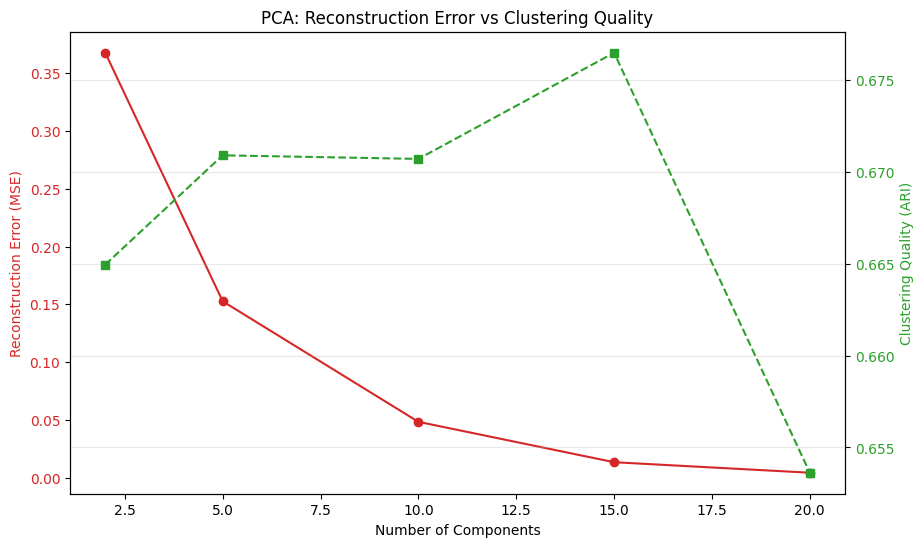

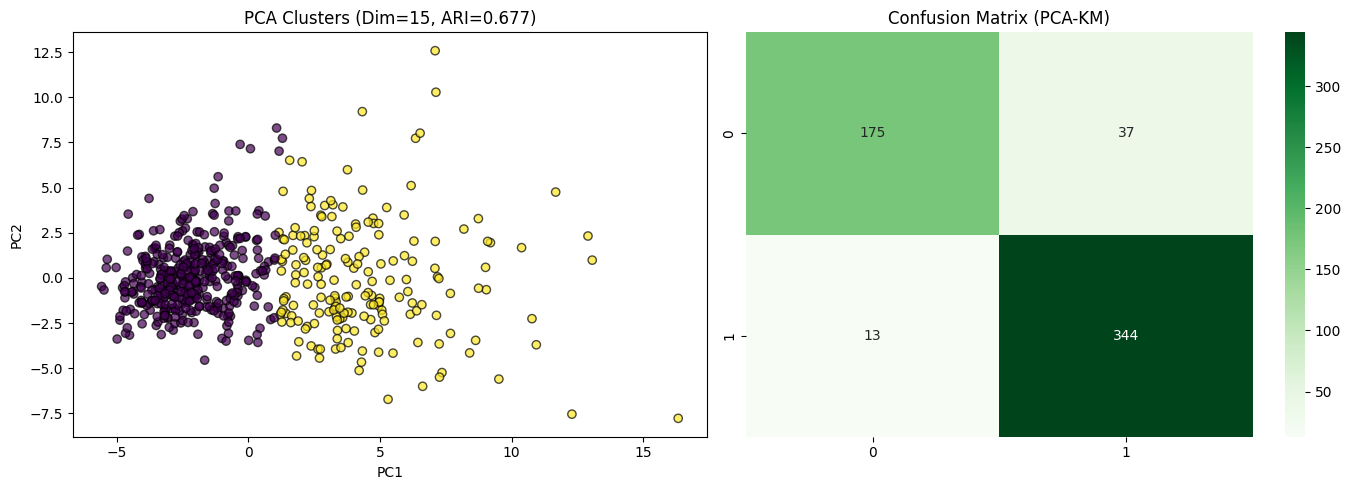

In [15]:
# --- EXPERIMENT 3: PCA + K-MEANS ---
max_feats = X.shape[1]
components_counts = [c for c in [2, 5, 10, 15, 20] if c <= max_feats]
if not components_counts: components_counts = [max_feats] # Fallback

errors, variances, ari_scores = [], [], []

best_pca_ari = -1
best_pca_record = {}
best_pca_labels = None
best_pca_X = None
best_dim = components_counts[0]

print(f"{'Dim':<5} | {'Var(%)':<8} | {'MSE':<8} | {'ARI':<8} | {'Sil':<8}")
print("-" * 55)

for com in components_counts:
    t0 = time.time()
    
    # 1. PCA Projection
    pca = ManualPCA(n_components=com)
    # Ensure X is scaled if ManualPCA doesn't handle it
    X_projected = pca.fit_transform(X) 
    
    # 2. Reconstruction Error
    current_error = pca.compute_reconstruction_error(X, X_projected)
    variance = np.sum(pca.explained_variance_ratio) * 100
    
    # 3. K-Means 
    k_opt = 2 
    kmeans = Kmeans(k=k_opt, max_iter=100)
    kmeans.fit(X_projected)
    labels = kmeans.predict(X_projected)
    t_elapsed = time.time() - t0
    
    # 4. Metrics
    ari = EvaluationMetrics.adjusted_rand_index(y, labels)
    sil = EvaluationMetrics.silhouette_score(X_projected, labels)
    db = EvaluationMetrics.davies_bouldin(X_projected, labels)
    nmi = EvaluationMetrics.normalized_mutual_info(y, labels)
    pur = EvaluationMetrics.purity(y, labels)
    
    errors.append(current_error)
    variances.append(variance)
    ari_scores.append(ari)
    
    print(f"{com:<5} | {variance:<8.1f} | {current_error:<8.4f} | {ari:<8.3f} | {sil:<8.3f}")
    
    # Track Best
    if ari > best_pca_ari:
        best_pca_ari = ari
        best_dim = com
        best_pca_labels = labels
        best_pca_X = X_projected
        best_pca_record = {
            'Method': 'PCA-KM',
            'ARI': ari, 'NMI': nmi, 'Purity': pur,
            'Silhouette': sil, 'DBI': db, 'CH': 0,
            'MSE': current_error, 'VarExpl': variance,
            'Time (s)': t_elapsed
        }

# Store in Global Results
GLOBAL_RESULTS = [res for res in GLOBAL_RESULTS if res.get('Method') != 'PCA-KM']
if best_pca_record:
    GLOBAL_RESULTS.append(best_pca_record)

# --- Plots ---
fig, ax1 = plt.subplots(figsize=(10, 6))
color = "tab:red"
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Reconstruction Error (MSE)", color=color)
ax1.plot(components_counts, errors, marker="o", color=color, label="Error")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Clustering Quality (ARI)", color=color)
ax2.plot(components_counts, ari_scores, marker="s", linestyle="--", color=color, label="ARI")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("PCA: Reconstruction Error vs Clustering Quality")
plt.grid(True, alpha=0.3)
plt.show()

# --- Visuals: Best PCA Model ---
if best_pca_labels is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. 2D Projection (using first 2 PCs of the best projection)
    # If best_dim >= 2, we just take the first 2 columns.
    vis_x = best_pca_X[:, :2] if best_pca_X.shape[1] >= 2 else best_pca_X
    axes[0].scatter(vis_x[:, 0], vis_x[:, 1], c=best_pca_labels, cmap='viridis', edgecolor='k', alpha=0.7)
    axes[0].set_title(f'PCA Clusters (Dim={best_dim}, ARI={best_pca_ari:.3f})')
    axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')

    # 2. Confusion Matrix
    mapped_labels = map_labels(y, best_pca_labels)
    sns.heatmap(confusion_matrix(y, mapped_labels), annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('Confusion Matrix (PCA-KM)')
    
    plt.tight_layout(); plt.show()

# --- Statistical Data Collection ---
PAIRED_DATA['PCA-KM'] = []
print(f"Collecting stats for PCA (Dim={best_dim}) + KMeans...")
for _ in range(10):
    p = ManualPCA(n_components=best_dim)
    xp = p.fit_transform(X)
    k = Kmeans(k=2, max_iter=100) # Use same k_opt
    k.fit(xp)
    l = k.predict(xp)
    PAIRED_DATA['PCA-KM'].append(EvaluationMetrics.adjusted_rand_index(y, l))

## Experiment 4 (GMM after PCA)

Dim   | Full     | Tied     | Diag     | Spherical
-------------------------------------------------------
2     | 0.627    | 0.387    | 0.632    | 0.616   
3     | 0.599    | 0.345    | 0.599    | 0.604   
5     | 0.793    | 0.327    | 0.452    | 0.604   
10    | 0.596    | 0.350    | 0.044    | 0.561   
15    | 0.818    | 0.331    | 0.073    | 0.566   
20    | 0.664    | 0.044    | 0.054    | 0.561   


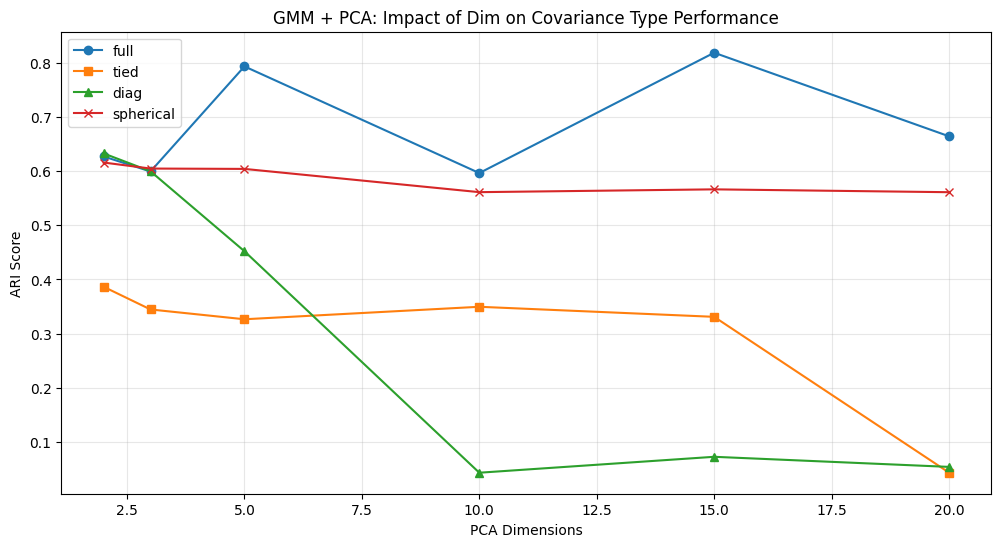

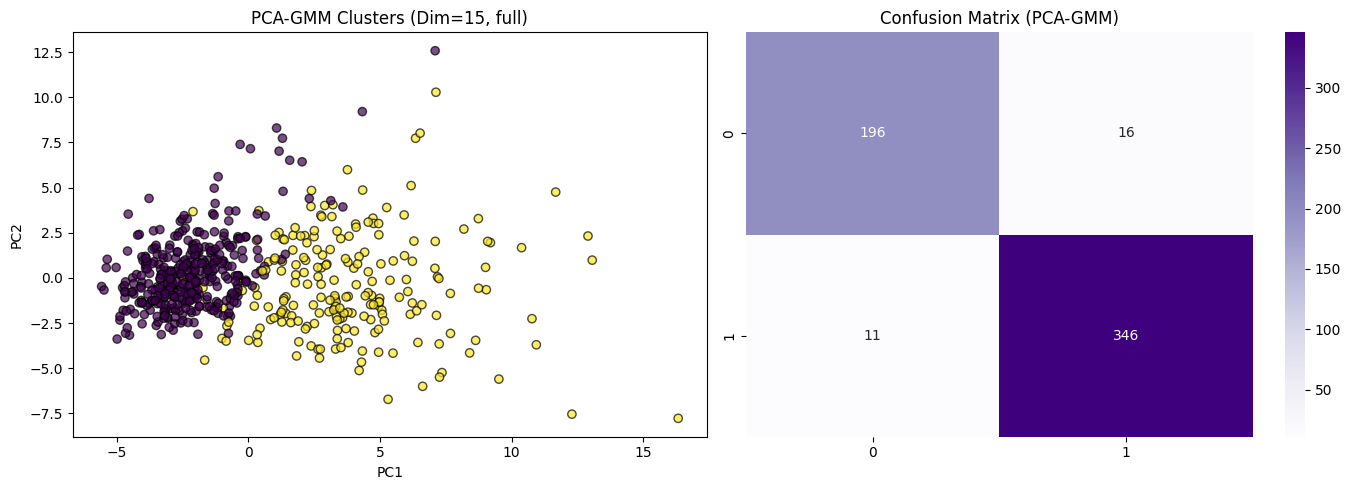

In [16]:
# --- EXPERIMENT 4: PCA + GMM ---
max_feats = X.shape[1]
dimensions = [d for d in [2, 3, 5, 10, 15, 20] if d <= max_feats]
if not dimensions: dimensions = [max_feats]

cov_types = ["full", "tied", "diag", "spherical"]
results_exp4 = {ctype: [] for ctype in cov_types}

# Track Best Config
best_pg_ari = -1
best_pg_config = None # (dim, cov_type)
best_pg_labels = None
best_pg_X = None
best_pg_record = {}

k_opt = 2 # As specified

print(f"{'Dim':<5} | {'Full':<8} | {'Tied':<8} | {'Diag':<8} | {'Spherical':<8}")
print("-" * 55)

for dim in dimensions:
    # 1. PCA
    pca = ManualPCA(n_components=dim)
    X_pca = pca.fit_transform(X)
    
    scores_row = []
    
    for ctype in cov_types:
        try:
            t0 = time.time()
            # 2. GMM
            gmm = GaussianMixtureModel(n_components=k_opt, covariance_type=ctype, max_iter=100, random_state=42)
            gmm.fit(X_pca)
            probs, _ = gmm._e_step(X_pca)
            labels = np.argmax(probs, axis=1)
            t_elapsed = time.time() - t0
            
            # 3. Metrics
            ari = EvaluationMetrics.adjusted_rand_index(y, labels)
            
            # Metrics for Global Table
            if ari > best_pg_ari:
                sil = EvaluationMetrics.silhouette_score(X_pca, labels)
                db = EvaluationMetrics.davies_bouldin(X_pca, labels)
                nmi = EvaluationMetrics.normalized_mutual_info(y, labels)
                pur = EvaluationMetrics.purity(y, labels)
                bic = gmm.bic(X_pca)
                aic = gmm.aic(X_pca)
                
                best_pg_ari = ari
                best_pg_config = (dim, ctype)
                best_pg_labels = labels
                best_pg_X = X_pca
                best_pg_record = {
                    'Method': 'PCA-GMM',
                    'ARI': ari, 'NMI': nmi, 'Purity': pur,
                    'Silhouette': sil, 'DBI': db, 'CH': 0,
                    'BIC': bic, 'AIC': aic,
                    'Time (s)': t_elapsed
                }

            results_exp4[ctype].append(ari)
            scores_row.append(ari)
            
        except:
            results_exp4[ctype].append(0)
            scores_row.append(0)
            
    print(f"{dim:<5} | {scores_row[0]:<8.3f} | {scores_row[1]:<8.3f} | {scores_row[2]:<8.3f} | {scores_row[3]:<8.3f}")

# Store Global
GLOBAL_RESULTS = [res for res in GLOBAL_RESULTS if res.get('Method') != 'PCA-GMM']
if best_pg_record:
    GLOBAL_RESULTS.append(best_pg_record)

# Plot: Impact of Dimensions
plt.figure(figsize=(12, 6))
markers = {"full": "o", "tied": "s", "diag": "^", "spherical": "x"}
for ctype in cov_types:
    plt.plot(dimensions, results_exp4[ctype], marker=markers[ctype], label=ctype)
plt.title("GMM + PCA: Impact of Dim on Covariance Type Performance")
plt.xlabel("PCA Dimensions"); plt.ylabel("ARI Score"); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Visuals: Best Model
if best_pg_labels is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 2D Projection
    vis_x = best_pg_X[:, :2] if best_pg_X.shape[1] >= 2 else best_pg_X
    axes[0].scatter(vis_x[:, 0], vis_x[:, 1], c=best_pg_labels, cmap='viridis', edgecolor='k', alpha=0.7)
    axes[0].set_title(f'PCA-GMM Clusters (Dim={best_pg_config[0]}, {best_pg_config[1]})')
    axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')

    # Confusion Matrix
    mapped_labels = map_labels(y, best_pg_labels)
    sns.heatmap(confusion_matrix(y, mapped_labels), annot=True, fmt='d', cmap='Purples', ax=axes[1])
    axes[1].set_title('Confusion Matrix (PCA-GMM)')
    plt.tight_layout(); plt.show()

# Statistical Data Collection
if best_pg_config:
    PAIRED_DATA['PCA-GMM'] = []
    print(f"Collecting stats for PCA (Dim={best_pg_config[0]}) + GMM ({best_pg_config[1]})...")
    
    for _ in range(10):
        try:
            p = ManualPCA(n_components=best_pg_config[0])
            xp = p.fit_transform(X)
            g = GaussianMixtureModel(n_components=k_opt, covariance_type=best_pg_config[1], random_state=None)
            g.fit(xp)
            probs, _ = g._e_step(xp)
            l = np.argmax(probs, axis=1)
            PAIRED_DATA['PCA-GMM'].append(EvaluationMetrics.adjusted_rand_index(y, l))
        except: pass

## Experiment 5 (Autoencoder + K-Means)

Starting Exp 5: Autoencoder + K-Means (k=2)...
Dim   | MSE      | ARI      | Sil     
----------------------------------------
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0860
Epoch 100, MSE=0.0838
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0833
2     | 0.0832   | 0.014    | 0.482   
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.0857
Epoch 100, MSE=0.0837
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0832
5     | 0.0832   | 0.663    | 0.433   
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0861
Epoch 100, MSE=0.0838
Epoch 150, MSE=0.0835
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0833
10    | 0.0833   | 0.498    | 0.402   
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0864
Epoch 100, MSE=0.0839
Epoch 150, MSE=0.0835
Epoch 200, MSE=0.0834
Epoch 250, MSE=0.0833
15    | 0.0833   | 0.623    | 0.405   
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0865
Epoch 100, MSE=0.0839
Epoch 150, MSE=0.0835
Epoch 200, MSE=0.0834
Epoch 250, MSE=0.0833
20    | 0.0833   | 0.736    | 0.388   


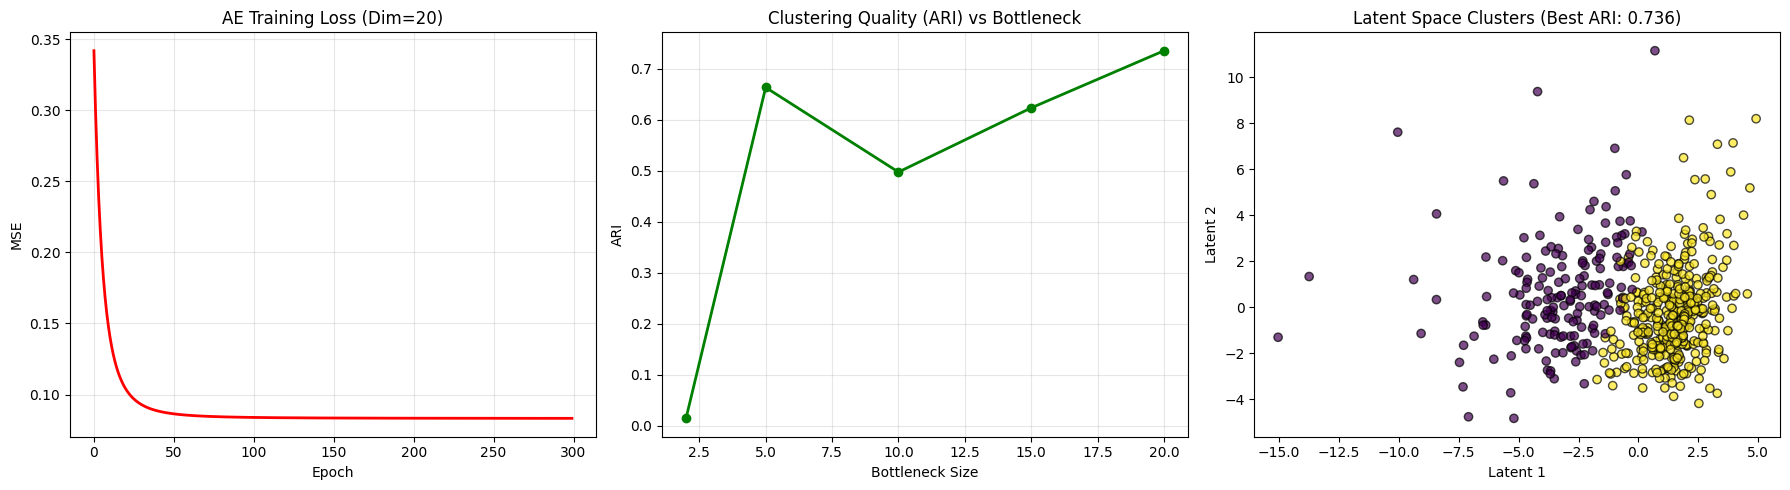

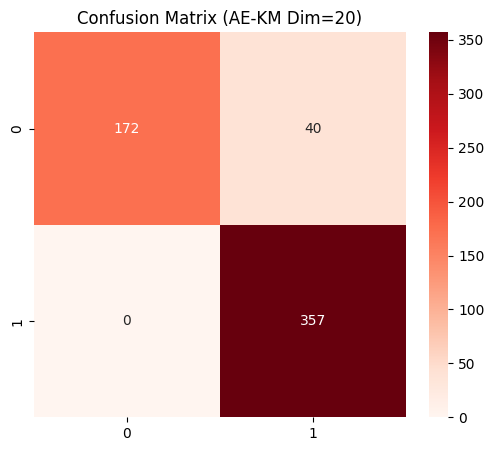

Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1035
Epoch 100, MSE=0.1005
Epoch 150, MSE=0.1003
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1040
Epoch 100, MSE=0.1010
Epoch 150, MSE=0.1008
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.1051
Epoch 100, MSE=0.1021
Epoch 150, MSE=0.1019
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1039
Epoch 100, MSE=0.1010
Epoch 150, MSE=0.1008
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1043
Epoch 100, MSE=0.1014
Epoch 150, MSE=0.1012
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1038
Epoch 100, MSE=0.1008
Epoch 150, MSE=0.1006
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.1051
Epoch 100, MSE=0.1022
Epoch 150, MSE=0.1020
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1035
Epoch 100, MSE=0.1006
Epoch 150, MSE=0.1004
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.1045
Epoch 100, MSE=0.1016
Epoch 150, MSE=0.1014
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.1045
Epoch 100, MSE=0.1016
Epoch 150, MSE=0.1014


In [17]:


# --- EXPERIMENT 5: AUTOENCODER + K-MEANS ---
def min_max_scale(X):
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    divisor = max_val - min_val
    divisor[divisor == 0] = 1.0
    return (X - min_val) / divisor

# Scale for AE (Tanh expects -1 to 1)
X_ae_input = min_max_scale(X) * 2 - 1

bottleneck_sizes = [2, 5, 10, 15, 20]
input_dim = X.shape[1]
results_ae = {'dim': [], 'mse': [], 'ari': []}

# Track Best AE Model
best_ae_ari = -1
best_ae_dim = -1
best_ae_labels = None
best_ae_latent = None
best_ae_loss_hist = []
best_ae_record = {}

k_opt = 2  # As specified

print(f"Starting Exp 5: Autoencoder + K-Means (k={k_opt})...")
print(f"{'Dim':<5} | {'MSE':<8} | {'ARI':<8} | {'Sil':<8}")
print("-" * 40)

for b_dim in bottleneck_sizes:
    t0 = time.time()
    
    # 1. Train AE
    layer_dims = [input_dim, 20, b_dim, 20, input_dim]
    ae = Autoencoder(layer_dims, activation="tanh", lr=0.01, l2=1e-5)
    # Suppress output by not printing inside train if possible, or accept it
    losses = ae.train(X_ae_input, epochs=300, batch_size=64, decay=0.99)
    
    # 2. Encode
    X_encoded = ae.encode(X_ae_input)
    
    # 3. Cluster
    kmeans_ae = Kmeans(k=k_opt, init='kpp', max_iter=300)
    kmeans_ae.fit(X_encoded)
    y_pred_ae = kmeans_ae.predict(X_encoded)
    t_elapsed = time.time() - t0
    
    # 4. Metrics
    mse = losses[-1]
    ari = EvaluationMetrics.adjusted_rand_index(y, y_pred_ae)
    sil = EvaluationMetrics.silhouette_score(X_encoded, y_pred_ae)
    db = EvaluationMetrics.davies_bouldin(X_encoded, y_pred_ae)
    nmi = EvaluationMetrics.normalized_mutual_info(y, y_pred_ae)
    pur = EvaluationMetrics.purity(y, y_pred_ae)
    
    results_ae['dim'].append(b_dim)
    results_ae['mse'].append(mse)
    results_ae['ari'].append(ari)
    
    print(f"{b_dim:<5} | {mse:<8.4f} | {ari:<8.3f} | {sil:<8.3f}")
    
    # Track Best
    if ari > best_ae_ari:
        best_ae_ari = ari
        best_ae_dim = b_dim
        best_ae_labels = y_pred_ae
        best_ae_latent = X_encoded
        best_ae_loss_hist = losses
        best_ae_record = {
            'Method': 'AE-KM',
            'ARI': ari, 'NMI': nmi, 'Purity': pur,
            'Silhouette': sil, 'DBI': db, 'CH': 0,
            'MSE': mse,
            'Time (s)': t_elapsed
        }

# Store Global
GLOBAL_RESULTS = [res for res in GLOBAL_RESULTS if res.get('Method') != 'AE-KM']
if best_ae_record:
    GLOBAL_RESULTS.append(best_ae_record)

# --- Visualizations ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Training Loss (Best Model)
axes[0].plot(best_ae_loss_hist, 'r-', linewidth=2)
axes[0].set_title(f'AE Training Loss (Dim={best_ae_dim})')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
axes[0].grid(True, alpha=0.3)

# 2. ARI vs Bottleneck Size
axes[1].plot(results_ae['dim'], results_ae['ari'], 'g-o', linewidth=2)
axes[1].set_title('Clustering Quality (ARI) vs Bottleneck')
axes[1].set_xlabel('Bottleneck Size'); axes[1].set_ylabel('ARI')
axes[1].grid(True, alpha=0.3)

# 3. Latent Space Clusters
# If latent dim > 2, project to 2D for visualization
if best_ae_latent.shape[1] > 2:
    pca_vis = ManualPCA(n_components=2)
    vis_x = pca_vis.fit_transform(best_ae_latent)
else:
    vis_x = best_ae_latent

axes[2].scatter(vis_x[:, 0], vis_x[:, 1], c=best_ae_labels, cmap='viridis', edgecolor='k', alpha=0.7)
axes[2].set_title(f'Latent Space Clusters (Best ARI: {best_ae_ari:.3f})')
axes[2].set_xlabel('Latent 1'); axes[2].set_ylabel('Latent 2')

plt.tight_layout(); plt.show()

# Confusion Matrix
mapped_labels = map_labels(y, best_ae_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y, mapped_labels), annot=True, fmt='d', cmap='Reds')
plt.title(f'Confusion Matrix (AE-KM Dim={best_ae_dim})')
plt.show()

# --- Statistical Data Collection ---
if best_ae_dim != -1:
    PAIRED_DATA['AE-KM'] = []
    print(f"Collecting stats for AE (Dim={best_ae_dim}) + KMeans...")
    
    for _ in range(10):
        # Re-train fresh AE each time
        ae = Autoencoder([input_dim, 20, best_ae_dim, 20, input_dim], activation="tanh", lr=0.01, l2=1e-5)
        ae.train(X_ae_input, epochs=200, batch_size=64, decay=0.95)
        xe = ae.encode(X_ae_input)
        
        k = Kmeans(k=k_opt, max_iter=100)
        k.fit(xe)
        l = k.predict(xe)
        PAIRED_DATA['AE-KM'].append(EvaluationMetrics.adjusted_rand_index(y, l))

## Experiment 6 (GMM after Autoencoder & Comparison)

Starting Exp 6: Autoencoder + GMM (full)...
Dim   | ARI      | Sil      | DBI     
---------------------------------------------
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0859
Epoch 100, MSE=0.0837
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0833
2     | 0.233    | 0.234    | 4.601   
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.0859
Epoch 100, MSE=0.0837
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0833
5     | 0.307    | 0.223    | 2.302   
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0863
Epoch 100, MSE=0.0839
Epoch 150, MSE=0.0835
Epoch 200, MSE=0.0834
Epoch 250, MSE=0.0833
10    | 0.159    | 0.210    | 2.174   
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0860
Epoch 100, MSE=0.0838
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0833
15    | 0.214    | 0.223    | 1.781   
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0861
Epoch 100, MSE=0.0838
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0833
20    | 0.793    | 0.306    | 1.344   


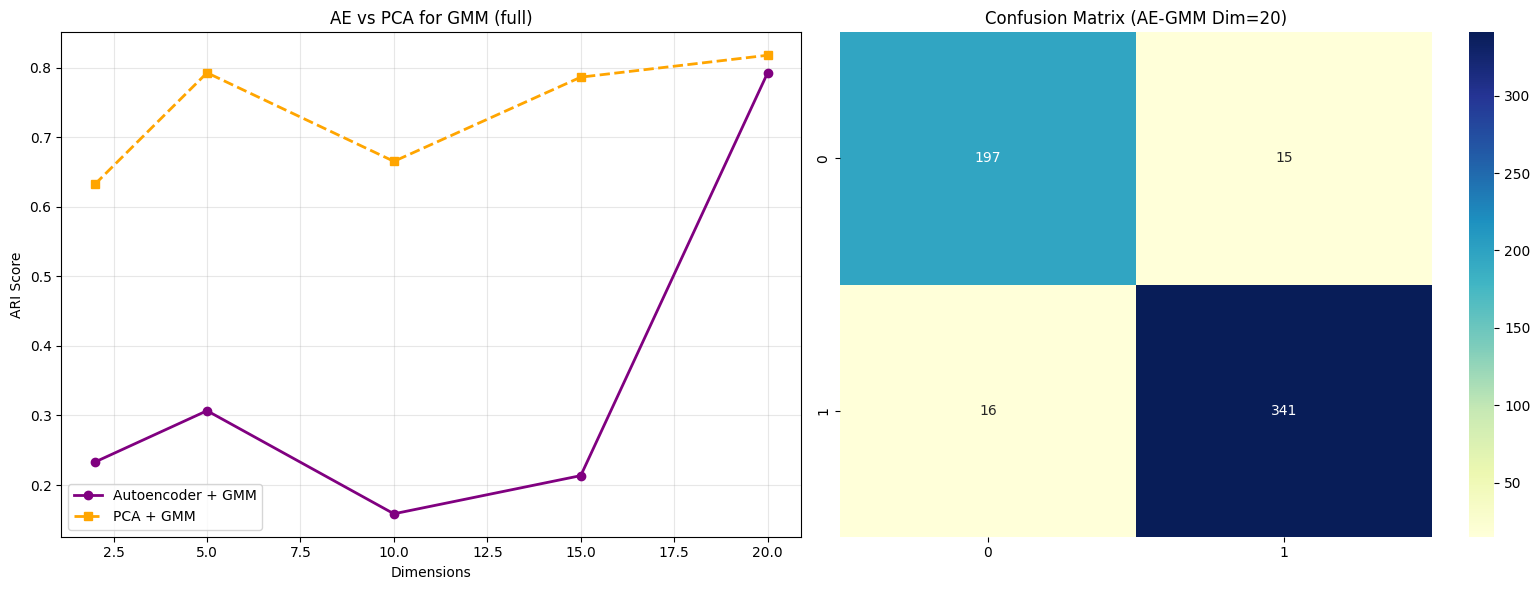

Epoch 0, MSE=0.3418
Epoch 50, MSE=0.1044
Epoch 100, MSE=0.1015
Epoch 150, MSE=0.1013
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1044
Epoch 100, MSE=0.1014
Epoch 150, MSE=0.1012
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1038
Epoch 100, MSE=0.1009
Epoch 150, MSE=0.1007
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1042
Epoch 100, MSE=0.1013
Epoch 150, MSE=0.1011
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1046
Epoch 100, MSE=0.1016
Epoch 150, MSE=0.1014
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.1045
Epoch 100, MSE=0.1016
Epoch 150, MSE=0.1014
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1034
Epoch 100, MSE=0.1005
Epoch 150, MSE=0.1003
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1039
Epoch 100, MSE=0.1009
Epoch 150, MSE=0.1007
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1041
Epoch 100, MSE=0.1011
Epoch 150, MSE=0.1009
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.1029
Epoch 100, MSE=0.0999
Epoch 150, MSE=0.0997


FINAL COMPREHENSIVE ANALYSIS

--- Method Performance Summary ---
 Method      ARI      NMI   Purity  Silhouette      DBI  Time (s)
PCA-GMM 0.818046 

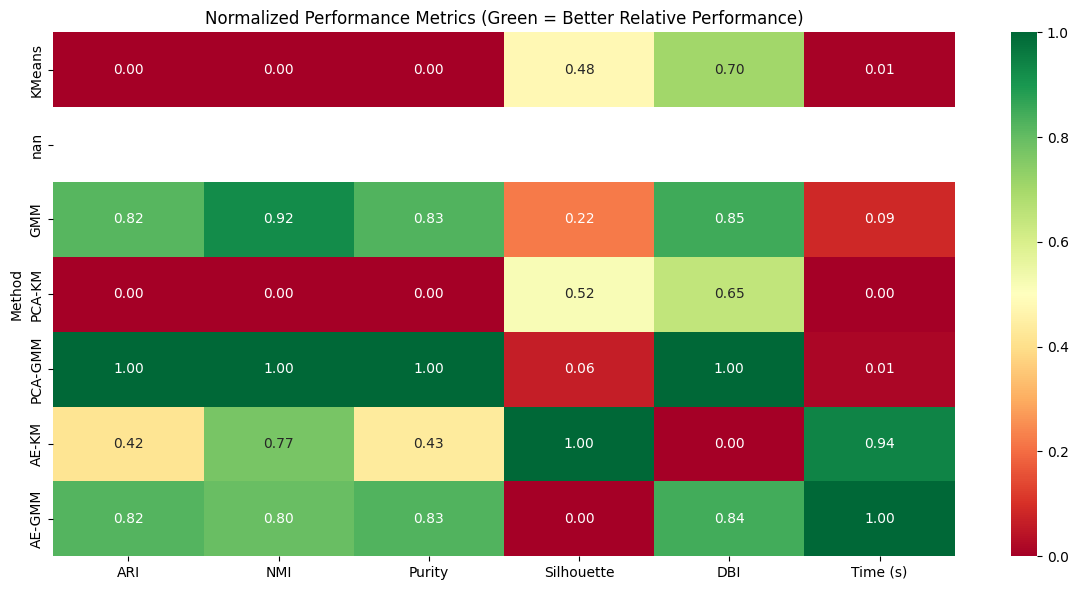


--- Statistical Significance (Paired T-Test on ARI) ---
KMeans vs GMM: t=6.420, p=0.0001 -> Significant
PCA-KM vs AE-KM: t=1.044, p=0.3238 -> Not Significant
PCA-GMM vs AE-GMM: t=-1.547, p=0.1562 -> Not Significant
GMM vs AE-GMM: t=0.489, p=0.6364 -> Not Significant

--- Computational Complexity Analysis ---
Method          | Time Complexity           | Space Complexity
-----------------------------------------------------------------
K-Means         | O(I * N * K * D)          | O(N * D + K * D)
GMM             | O(I * N * K * D^2)        | O(N * D + K * D^2)
PCA             | O(min(D^3, N*D^2))        | O(D^2)
Autoencoder     | O(E * N * W)              | O(W)
-----------------------------------------------------------------
N=Samples, D=Dimensions, K=Clusters, I=Iterations, E=Epochs, W=Weights


In [19]:
from scipy.stats import ttest_rel
# --- EXPERIMENT 6: AE + GMM ---
bottleneck_sizes = [2, 5, 10, 15, 20]
results_exp6 = {'dim': [], 'ari': [], 'silhouette': []}

cov_type_fixed = 'full'
best_aeg_ari = -1
best_aeg_dim = -1
best_aeg_labels = None
best_aeg_record = {}

print(f"Starting Exp 6: Autoencoder + GMM ({cov_type_fixed})...")
print(f"{'Dim':<5} | {'ARI':<8} | {'Sil':<8} | {'DBI':<8}")
print("-" * 45)

for b_dim in bottleneck_sizes:
    t0 = time.time()
    
    # 1. Train AE
    layer_dims = [X.shape[1], 20, b_dim, 20, X.shape[1]]
    ae = Autoencoder(layer_dims, activation="tanh", lr=0.01, l2=1e-5)
    ae.train(X_ae_input, epochs=300, batch_size=64, decay=0.99)
    
    # 2. Encode
    X_encoded = ae.encode(X_ae_input)
    scaler_latent = StandardScaler()
    X_encoded_scaled = scaler_latent.fit_transform(X_encoded)
    
    # 3. GMM
    try:
        gmm_ae = GaussianMixtureModel(n_components=2, covariance_type=cov_type_fixed, 
                                      max_iter=100, random_state=42, reg_covar=1e-6)
        gmm_ae.fit(X_encoded_scaled)
        probs, _ = gmm_ae._e_step(X_encoded_scaled)
        y_pred = np.argmax(probs, axis=1)
        t_elapsed = time.time() - t0
        
        # 4. Metrics
        ari = EvaluationMetrics.adjusted_rand_index(y, y_pred)
        sil = EvaluationMetrics.silhouette_score(X_encoded_scaled, y_pred)
        db = EvaluationMetrics.davies_bouldin(X_encoded_scaled, y_pred)
        nmi = EvaluationMetrics.normalized_mutual_info(y, y_pred)
        pur = EvaluationMetrics.purity(y, y_pred)
        bic = gmm_ae.bic(X_encoded_scaled)
        aic = gmm_ae.aic(X_encoded_scaled)
        
        results_exp6['dim'].append(b_dim)
        results_exp6['ari'].append(ari)
        results_exp6['silhouette'].append(sil)
        
        print(f"{b_dim:<5} | {ari:<8.3f} | {sil:<8.3f} | {db:<8.3f}")
        
        if ari > best_aeg_ari:
            best_aeg_ari = ari
            best_aeg_dim = b_dim
            best_aeg_labels = y_pred
            best_aeg_record = {
                'Method': 'AE-GMM',
                'ARI': ari, 'NMI': nmi, 'Purity': pur,
                'Silhouette': sil, 'DBI': db, 'CH': 0,
                'BIC': bic, 'AIC': aic,
                'Time (s)': t_elapsed
            }
            
    except Exception as e:
        print(f"Error dim {b_dim}: {e}")
        results_exp6['dim'].append(b_dim)
        results_exp6['ari'].append(0)
        results_exp6['silhouette'].append(0)

# Store Global
GLOBAL_RESULTS = [res for res in GLOBAL_RESULTS if res.get('Method') != 'AE-GMM']
if best_aeg_record:
    GLOBAL_RESULTS.append(best_aeg_record)

# --- Comparison Loop ---
pca_gmm_scores = []
max_feats = X.shape[1]

for d in bottleneck_sizes:
    safe_d = min(d, max_feats)
    pca_temp = ManualPCA(n_components=safe_d)
    X_pca_temp = pca_temp.fit_transform(X)
    
    try:
        gmm_temp = GaussianMixtureModel(n_components=2, covariance_type=cov_type_fixed, 
                                        random_state=42, reg_covar=1e-6)
        gmm_temp.fit(X_pca_temp)
        probs_temp, _ = gmm_temp._e_step(X_pca_temp)
        pca_gmm_scores.append(EvaluationMetrics.adjusted_rand_index(y, np.argmax(probs_temp, axis=1)))
    except:
        pca_gmm_scores.append(0)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Comparison Plot
axes[0].plot(results_exp6['dim'], results_exp6['ari'], marker='o', color='purple', linewidth=2, label='Autoencoder + GMM')
axes[0].plot(bottleneck_sizes, pca_gmm_scores, marker='s', linestyle='--', color='orange', linewidth=2, label='PCA + GMM')
axes[0].set_title(f'AE vs PCA for GMM ({cov_type_fixed})')
axes[0].set_xlabel('Dimensions'); axes[0].set_ylabel('ARI Score')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# 2. Confusion Matrix
if best_aeg_labels is not None:
    mapped_labels = map_labels(y, best_aeg_labels)
    sns.heatmap(confusion_matrix(y, mapped_labels), annot=True, fmt='d', cmap='YlGnBu', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix (AE-GMM Dim={best_aeg_dim})')

plt.tight_layout(); plt.show()

# --- Paired Stats ---
if best_aeg_dim != -1:
    PAIRED_DATA['AE-GMM'] = []
    print(f"Collecting stats for AE (Dim={best_aeg_dim}) + GMM...")
    for _ in range(10):
        ae = Autoencoder([X.shape[1], 20, best_aeg_dim, 20, X.shape[1]], activation="tanh", lr=0.01, l2=1e-5)
        ae.train(X_ae_input, epochs=200, batch_size=64, decay=0.95)
        xe = StandardScaler().fit_transform(ae.encode(X_ae_input))
        
        g = GaussianMixtureModel(n_components=2, covariance_type=cov_type_fixed, random_state=None)
        g.fit(xe)
        probs, _ = g._e_step(xe)
        l = np.argmax(probs, axis=1)
        PAIRED_DATA['AE-GMM'].append(EvaluationMetrics.adjusted_rand_index(y, l))

# ==========================================
#      FINAL STATISTICAL ANALYSIS
# ==========================================

print("\n\n" + "="*40)
print("FINAL COMPREHENSIVE ANALYSIS")
print("="*40)

# 1. Global Metrics Table
df_final = pd.DataFrame(GLOBAL_RESULTS)
if not df_final.empty:
    cols = ['Method', 'ARI', 'NMI', 'Purity', 'Silhouette', 'DBI', 'Time (s)']
    # Filter columns that exist
    cols = [c for c in cols if c in df_final.columns]
    print("\n--- Method Performance Summary ---")
    print(df_final[cols].sort_values(by='ARI', ascending=False).to_string(index=False))

    # 2. Normalized Heatmap
    plt.figure(figsize=(12, 6))
    # Select numeric columns only
    df_numeric = df_final.set_index('Method')[cols[1:]].astype(float)
    # Normalize (Min-Max) for visualization
    df_norm = (df_numeric - df_numeric.min()) / (df_numeric.max() - df_numeric.min())
    
    sns.heatmap(df_norm, annot=True, cmap='RdYlGn', fmt='.2f')
    plt.title('Normalized Performance Metrics (Green = Better Relative Performance)')
    plt.tight_layout(); plt.show()

# 3. Paired T-Tests
print("\n--- Statistical Significance (Paired T-Test on ARI) ---")
comparisons = [
    ('KMeans', 'GMM'),
    ('PCA-KM', 'AE-KM'),
    ('PCA-GMM', 'AE-GMM'),
    ('GMM', 'AE-GMM')
]

for m1, m2 in comparisons:
    data1 = PAIRED_DATA.get(m1, [])
    data2 = PAIRED_DATA.get(m2, [])
    
    if len(data1) >= 5 and len(data2) >= 5:
        # Trim to matching length
        min_len = min(len(data1), len(data2))
        stat, pval = ttest_rel(data1[:min_len], data2[:min_len])
        sig = "Significant" if pval < 0.05 else "Not Significant"
        print(f"{m1} vs {m2}: t={stat:.3f}, p={pval:.4f} -> {sig}")
    else:
        print(f"{m1} vs {m2}: Insufficient data for test.")

# 4. Complexity Analysis
print("\n--- Computational Complexity Analysis ---")
print(f"{'Method':<15} | {'Time Complexity':<25} | {'Space Complexity'}")
print("-" * 65)
print(f"{'K-Means':<15} | O(I * N * K * D)          | O(N * D + K * D)")
print(f"{'GMM':<15} | O(I * N * K * D^2)        | O(N * D + K * D^2)")
print(f"{'PCA':<15} | O(min(D^3, N*D^2))        | O(D^2)")
print(f"{'Autoencoder':<15} | O(E * N * W)              | O(W)")
print("-" * 65)
print("N=Samples, D=Dimensions, K=Clusters, I=Iterations, E=Epochs, W=Weights")

-------------------------------------------------------------------------------------------------------------------------

1. For ARI, NMI, Purity, Silhouette (Higher is Better)
0.00 means "Worst Score".

Because these metrics want high numbers, the method with the lowest raw number gets converted to 0.

Example: In your table, KMeans and PCA-KM have the lowest ARI (0.676505). Since this is the minimum value in that column, the heatmap turns it into 0.00.

2. For DBI and Time (Lower is Better)
0.00 means "Best Score" (Fastest / Tightest).

Because these metrics want low numbers, the method with the smallest raw number gets converted to 0.

Example (Time): PCA-KM is the fastest (0.000997s). Since this is the smallest number in the "Time" column, it becomes 0.00.

Example (DBI): AE-KM has the lowest Davies-Bouldin Index (1.13). Since lower is better for DBI, this 0.00 actually represents the winning score for that metric.